# UTMIST AI2: Demo Notebook
Hi! Welcome to the **demo notebook** for the UTMIST AI2 Reinforcement Learning Tournament. This notebook contains a simple reinforcement learning setup similar to the one we'll be using on the day, such that participants can get familiar with the tools and modules used during the competition. This is heavily adapted from the following notebook, which you may visit for a more complete set of tutorials: [Google Stable-Baselines3 Tutorial: Part 1](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/stable_baselines_getting_started.ipynb)

We'll be covering a straightforward usage of Stable-Baselines3 (a Reinforcement Learning library) on a game called CartPole, which has a cart trying to balance a pole as it moves. In order, we'll follow:


*   Imports
*   Creating the gym env and agent
*   Preparing the env to gather data
*   Training the agent
*   Running the trained model
*   Evaluating the trained model
*   Video playback

This notebook might jump into some unfamiliar terms: don't worry! We'll be covering all of these during workshops on the day, and will have mentors around to help get your code running. If you'd like to get started learning some of these terms, feel free to read through the [OpenAI SpinningUp Docs: Part 1](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html), which cover the central concepts in RL quite well.

## Intro to Reinforcement Learning (RL): What are we working with? How does any of this function?

Reinforcement Learning is like teaching a robot to make smart decisions through trial and error. Here's how it works in simple terms, using key concepts from **OpenAI SpinningUp**:

<p align="center">
  <img src="https://i.imgur.com/HOCBdqB.png" alt="RL Schema" width="300"/>
</p>

---

### 1. **Agent & Environment**  
- **Agent**: The learner (e.g., a robot) that makes decisions.  
- **Environment**: The world the agent interacts with. At each step:  
  - The agent observes the environment (partially or fully).  
  - The agent takes an **action**.  
  - The environment updates and gives a **reward** (feedback).  

---

### 2. **States ($s$) vs. Observations ($o$)**  
- **State ($s$)**: A *complete* description of the environment (e.g., exact robot joint positions).  
- **Observation ($o$)**: A *partial* view the agent sees (e.g., sensor readings like camera pixels).  
- Example: In a video game, the game's internal memory is the *state*, while the screen pixels are the *observation*.  

---

### 3. **Action Spaces ($A$)**  
The set of possible actions the agent can take:  
- **Discrete**: Finite choices (e.g., $\{\text{left, right, jump}\}$ in Atari games).  
- **Continuous**: Infinite choices (e.g., steering angle $\in [-30°, 30°]$ for a self-driving car).  

---

### 4. **Policies ($\pi$): The Agent's Strategy**  
A policy decides *what action to take* given a state:  
- **Deterministic Policy ($\mu$):** Direct mapping:  
  $
  a_t = μ(s_t)  
  $

  Example: "If obstacle ahead, turn right."  

- **Stochastic Policy ($\pi$):** Probability distribution:  
  $
  a_t \sim π(⋅|s_t)  
  $

  Example: "If obstacle ahead, 70% chance turn left, 30% turn right."

In deep RL, policies are often neural networks. For example:  
```python
# A simple neural network policy for continuous actions (PyTorch)
policy_net = nn.Sequential(
    nn.Linear(obs_dim, 64),  # Takes observation as input
    nn.Tanh(),
    nn.Linear(64, act_dim)   # Outputs action values
)
```

---

### 5. **Rewards & Return**  
- **Reward ($r_t$)**: Immediate feedback (e.g., $+10$ for reaching a goal, $-1$ for hitting a wall).  
- **Return ($R(\tau)$):** Total reward over a **trajectory**. Two common types:  
  - **Finite-horizon**: Sum of rewards over $T$ steps:  
    $
    R(τ) = \sum_{t=0}^T r_t
    $

  - **Infinite-horizon (discounted)**: Sum of *all* future rewards, with discount factor $γ \in (0,1)$:  
    $
    R(τ) = \sum_{t=0}^∞ γ^t r_t
    $

    (Why? $1 today > $1 tomorrow! Ensures math works for infinite timelines.)

---

### 6. **Trajectories (`τ`)**  
A sequence of interactions:  
$
τ = (s_0, a_0, r_0, s_1, a_1, r_1, ...)
$

- Starts with $s_0 \sim ρ_0$ (initial state distribution).  
- Transitions follow environment rules:  
  - Deterministic: $s_{t+1} = f(s_t, a_t)$  
  - Stochastic: $s_{t+1} \sim P(⋅|s_t, a_t)$

---

### The RL Problem  
The agent’s goal is to find the **optimal policy `π*`** that maximizes *expected return*:  
$
π^* = \arg\max_π \mathbb{E}_{τ \sim π}[R(τ)]
$

This means tuning `π` (e.g., neural network weights) to make good decisions *on average*.

---

**Key Takeaway**: RL is a loop of **actions**, **observations**, and **rewards** where the agent learns to maximize long-term success. Think of it like training a dog with treats, but with math! 🐕🎮

In [ ]:
!pip install gymnasium pygame==2.6.1 pymunk==6.2.1 scikit-image scikit-video sympy==1.5.1
!pip install stable_baselines3 sb3-contrib

ERROR: Operation cancelled by user


## Imports
Stable-Baselines works on environments that follow the [gym interface](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).
You can find a list of available environment [here](https://gym.openai.com/envs/#classic_control).

It is also recommended to check the [source code](https://github.com/openai/gym) to learn more about the observation and action space of each env, as gym does not have a proper documentation.
Not all algorithms can work with all action spaces, you can find more in this [recap table](https://stable-baselines.readthedocs.io/en/master/guide/algos.html)

In [ ]:
import gymnasium as gym # provides a standardized format for the game / environment

The first thing you need to import is the RL model, check the documentation to know what you can use on which problem

In [ ]:
from stable_baselines3 import PPO # PPO : the learning algorithm we'll use

## Creating the Gym env and Instantiating the agent

For this example, we will use CartPole environment, a classic control problem.

"A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. "

Cartpole environment: [https://gymnasium.farama.org/environments/classic_control/cart_pole/](https://gymnasium.farama.org/environments/classic_control/cart_pole/)

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)

Note: vectorized environments allow to easily multiprocess training. In this example, we are using only one process, hence the DummyVecEnv.

We chose the MlpPolicy because input of CartPole is a feature vector, not images.

The type of action to use (discrete/continuous) will be automatically deduced from the environment action space


Here we are using the [Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html) algorithm, which is an Actor-Critic method: it uses a value function to improve the policy gradient descent (by reducing the variance).

It combines ideas from [A2C](https://stable-baselines.readthedocs.io/en/master/modules/a2c.html) (having multiple workers and using an entropy bonus for exploration) and [TRPO](https://stable-baselines.readthedocs.io/en/master/modules/trpo.html) (it uses a trust region to improve stability and avoid catastrophic drops in performance).

PPO is an on-policy algorithm, which means that the trajectories used to update the networks must be collected using the latest policy.
It is usually less sample efficient than off-policy alorithms like [DQN](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html), [SAC](https://stable-baselines.readthedocs.io/en/master/modules/sac.html) or [TD3](https://stable-baselines.readthedocs.io/en/master/modules/td3.html), but is much faster regarding wall-clock time.


In [ ]:
# Create the CartPole environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

## Wrapping for Plotting

Stable Baselines3 has some built-in plotting helpers that you can find in `stable_baselines3.common.results_plotter`.

In [ ]:
import os
from stable_baselines3.common.monitor import Monitor

# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Wrap the environment: logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

# Setup the PPO Algorithm and model
model = PPO("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env in a DummyVecEnv.


## Training

In [ ]:
# Train the model for 35,000 steps
model.learn(total_timesteps=35_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 21.5     |
| time/              |          |
|    fps             | 1038     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.9        |
|    ep_rew_mean          | 26.9        |
| time/                   |             |
|    fps                  | 728         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008803906 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.00115    |
|    learning_rate        | 0.

KeyboardInterrupt: 

## Running the Model
We can run the model as such, by looping back and forth between observations from the environment and actions from the model. You can choose to take data from the run here, perhaps by appending it to a list for plotting. We'll take a look at built-in plotting functionality later in this notebook.

In [ ]:
vec_env = model.get_env()
obs = vec_env.reset()
for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    # VecEnv resets automatically
    # Could log the reward, actions, obs here - up to you!

## Evaluation
Stable-Baselines3 provides you with a helper function to evaluate your model:

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

# Use a separate environement for evaluation
eval_env = gym.make("CartPole-v1", render_mode="rgb_array")

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:500.00 +/- 0.00


We can also plot the results that have been saved to the .csv:

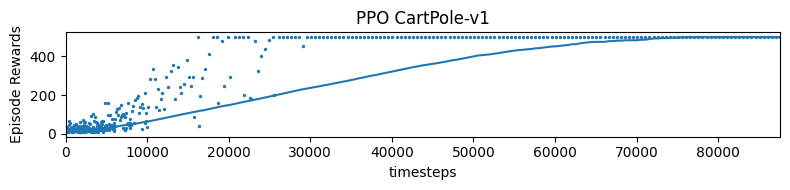

In [ ]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO CartPole-v1"
)

## Video Playback
We can also setup recording for the environment!

In [ ]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make("CartPole-v1", render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

In [ ]:
record_video("CartPole-v1", model, video_length=500, prefix="ppo-cartpole")

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Saving video to /content/videos/ppo-cartpole-step-0-to-step-500.mp4


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/ppo-cartpole-step-0-to-step-500.mp4.
Moviepy - Writing video /content/videos/ppo-cartpole-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/ppo-cartpole-step-0-to-step-500.mp4


In [ ]:
show_videos("videos", prefix="ppo")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
